In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import re
%matplotlib inline

In [9]:
# download the male_surnames_rus.txt file from github
!curl https://raw.githubusercontent.com/Raven-SL/ru-pnames-list/master/lists/male_surnames_rus.txt -o male_surnames_rus.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  240k  100  240k    0     0  2152k      0 --:--:-- --:--:-- --:--:-- 2587k


In [10]:
surnames = open('male_surnames_rus.txt', 'r').read().splitlines()
surnames[:8]

['Абабков',
 'Абаимов',
 'Абакишин',
 'Абакулин',
 'Абакулов',
 'Абакумкин',
 'Абакумов',
 'Абакушин']

In [11]:
len(surnames)

14651

In [12]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(surnames))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'А', 2: 'Б', 3: 'В', 4: 'Г', 5: 'Д', 6: 'Е', 7: 'Ж', 8: 'З', 9: 'И', 10: 'К', 11: 'Л', 12: 'М', 13: 'Н', 14: 'О', 15: 'П', 16: 'Р', 17: 'С', 18: 'Т', 19: 'У', 20: 'Ф', 21: 'Х', 22: 'Ц', 23: 'Ч', 24: 'Ш', 25: 'Щ', 26: 'Э', 27: 'Ю', 28: 'Я', 29: 'а', 30: 'б', 31: 'в', 32: 'г', 33: 'д', 34: 'е', 35: 'ж', 36: 'з', 37: 'и', 38: 'й', 39: 'к', 40: 'л', 41: 'м', 42: 'н', 43: 'о', 44: 'п', 45: 'р', 46: 'с', 47: 'т', 48: 'у', 49: 'ф', 50: 'х', 51: 'ц', 52: 'ч', 53: 'ш', 54: 'щ', 55: 'ъ', 56: 'ы', 57: 'ь', 58: 'э', 59: 'ю', 60: 'я', 61: 'ё', 0: '.'}


In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(surnames))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
N_chars = len(itos)

{1: 'А', 2: 'Б', 3: 'В', 4: 'Г', 5: 'Д', 6: 'Е', 7: 'Ж', 8: 'З', 9: 'И', 10: 'К', 11: 'Л', 12: 'М', 13: 'Н', 14: 'О', 15: 'П', 16: 'Р', 17: 'С', 18: 'Т', 19: 'У', 20: 'Ф', 21: 'Х', 22: 'Ц', 23: 'Ч', 24: 'Ш', 25: 'Щ', 26: 'Э', 27: 'Ю', 28: 'Я', 29: 'а', 30: 'б', 31: 'в', 32: 'г', 33: 'д', 34: 'е', 35: 'ж', 36: 'з', 37: 'и', 38: 'й', 39: 'к', 40: 'л', 41: 'м', 42: 'н', 43: 'о', 44: 'п', 45: 'р', 46: 'с', 47: 'т', 48: 'у', 49: 'ф', 50: 'х', 51: 'ц', 52: 'ч', 53: 'ш', 54: 'щ', 55: 'ъ', 56: 'ы', 57: 'ь', 58: 'э', 59: 'ю', 60: 'я', 61: 'ё', 0: '.'}


In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(cleaned_surnames):
  X, Y = [], []
  for w in surnames:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(surnames)
n1 = int(0.8*len(surnames))
n2 = int(0.9*len(surnames))

Xtr, Ytr = build_dataset(surnames[:n1])
Xdev, Ydev = build_dataset(surnames[n1:n2])
Xte, Yte = build_dataset(surnames[n2:])

torch.Size([130518, 3]) torch.Size([130518])
torch.Size([130518, 3]) torch.Size([130518])
torch.Size([130518, 3]) torch.Size([130518])


In [15]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 18],
        [ 0, 18, 37],
        ...,
        [29, 42, 52],
        [42, 52, 37],
        [52, 37, 42]])

In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((N_chars, 10), generator=g) # 33 is the number of characters in Russian alphabet
W1 = torch.randn((30, 200), generator=g) # Assuming input size 30 + 10 (one-hot vector)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, N_chars), generator=g) # Output size matches the number of characters in Russian alphabet
b2 = torch.randn(N_chars, generator=g) # Bias for the output layer
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters) # number of parameters in total

19282

In [18]:
for p in parameters:
  p.requires_grad = True

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lri = []
lossi = []
stepi = []

In [21]:
ix = torch.randint(0, Xtr.shape[0], (32,))

Xtr[ix].shape

torch.Size([32, 3])

In [22]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.01 if i < 100000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.3915934562683105


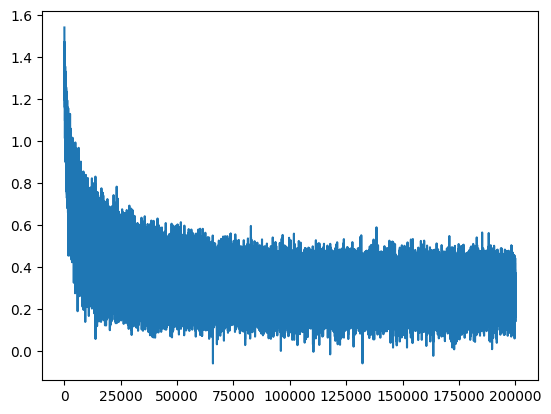

In [23]:
plt.plot(stepi, lossi)

In [24]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9721, grad_fn=<NllLossBackward0>)

In [25]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.9721, grad_fn=<NllLossBackward0>)

In [26]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.9721, grad_fn=<NllLossBackward0>)

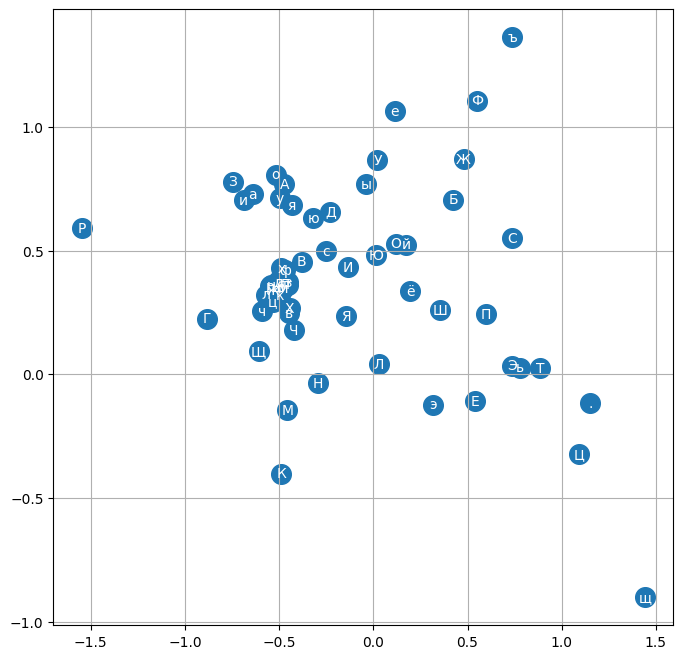

In [27]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [28]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

predicted_last_names = []
for _ in range(100):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
# We get rid of the final dot - nessasary step for further evaluation.
    last_name = ''.join(itos[i] for i in out)
    last_name = re.sub(r'\.', '', last_name)
    predicted_last_names.append(last_name)
    print(last_name)

Борашунов
Старейкин
Солтин
Насолин
Сохолов
Слерин
Козейкик
Дериков
Сотов
Родойньгин
Озалов
Ташкин
Деромодолев
Сваровников
Ершин
Тарменкороров
Аришенко
Амимов
Алеткин
Кнуведчис
Крив
Болоносов
Неменку
Степьков
Ковалоррусноцкил
Садьянин
Пркин
Рузановщинов
Балдамский
Левстин
Еебыпин
Цир
Ялехозчиков
Галюшкин
Лавов
Леонин
Ровик
Аним
Погипликов
Качевинов
Ариркинювин
Юньков
Демяков
Юлев
Радев
Париш
Пусавский
Яхов
Фбостий
Аник
Ювербатонникиреницкий
Вишкин
Олуев
Яромодин
Халазокатонякин
Воров
Орогкин
Анеричев
Евинский
Каженко
Воля
Верхуленкинов
Брак
Артюкикин
Зеисов
Юлюк
Самогурин
Ярпов
Амексин
Сонкин
Иров
Шаринцев
Стевич
Ганьшункин
Максинкин
Жашин
Закьмендоев
Плаанов
Тарашевий
Абоянов
Соваройчеткорып
Кульмункин
Плесоратоваленов
Алишгов
Рымориков
Савяткинов
Кандараммов
Еипыровский
Павлуков
Шимо
Атынов
Кохлисов
Чайтин
Рухарский
Федянцев
Зельпов
Антель
Тимамышкин
Вахиев
Ер


In [29]:
# Creating a DataFrame with a single column "predicted last names"
import pandas as pd
df = pd.DataFrame({"predicted last names": predicted_last_names})
df


,predicted last names
0,Борашунов
1,Старейкин
2,Солтин
3,Насолин
4,Сохолов
...,...
95,Зельпов
96,Антель
97,Тимамышкин
98,Вахиев


In [30]:
df.to_csv('predicted_last_names.csv')

In [31]:
# Evaluation 1: The presence of common suffixes in a list of generated last names.
#Sample list of suffixes
suffixes = ["ов", "ев", "ёв", "ин", "ич", "ын", "их", "ых", "ский", "цкий", "ый", "ой", "ий", "ян", "ник", "енко", "юк", "ер", "берг", "о"]

# Function to check for the presence of suffixes in a generated last name
def check_suffixes(last_name):
    for suffix in suffixes:
        if last_name.endswith(suffix):
            return True, suffix
    return False, None
# The result (True or False) is appended to the suffixes_eval list.
suffixes_eval = []
for last_name in predicted_last_names:
  has_suffix, suffix = check_suffixes(last_name)
  suffixes_eval.append(has_suffix)
# Calculates the mean of the column, which represents the proportion of last names that contain one of the suffixes.
df["has_suffix"] = suffixes_eval
df["has_suffix"].mean()


0.86

In [32]:
# Evaluation 2: Search generated last names in Google.
import requests
from bs4 import BeautifulSoup
#Specifies the URL of the Google search results page for the query "NLP" (example).
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"}
URL     = "https://www.google.com/search?q=NLP"
result = requests.get(URL, headers=headers)

soup = BeautifulSoup(result.content, 'html.parser')
#Finds the <div> element with the id "result-stats", which contains the total number of search results.
total_results_text = soup.find("div", {"id": "result-stats"}).find(text=True, recursive=False) # this will give you the outer text which is like 'About 1,410,000,000 results'
results_num = ''.join([num for num in total_results_text if num.isdigit()]) # now will clean it up and remove all the characters that are not a number.
print(results_num)

374000000


/var/folders/hg/l_2zgzbj1rv5jwmflpyb5y300000gn/T/ipykernel_17717/1759483325.py:11: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  total_results_text = soup.find("div", {"id": "result-stats"}).find(text=True, recursive=False) # this will give you the outer text which is like 'About 1,410,000,000 results'


In [33]:
# A function retrieves the number of search results for a given query name using Google search.
def get_num_search(name):
  headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"}
  URL     = "https://www.google.com/search?q=" + name
#It sends a GET request to the constructed URL and retrieves the HTML content of the search results page. Then, it parses the HTML content using BeautifulSoup.
  result = requests.get(URL, headers=headers)
  soup = BeautifulSoup(result.content, 'html.parser')
# The code is wrapped in a try-except block to handle cases where the total_results_text may not be found (they will be 0).
  total_results_text = soup.find("div", {"id": "result-stats"}).find(text=True, recursive=False) # this will give you the outer text which is like 'About 1,410,000,000 results'
  try:
    results_num = ''.join([num for num in total_results_text if num.isdigit()]) # now will clean it up and remove all the characters that are not a number .
  except:
    print(total_results_text)
    results_num = 0
  return int(results_num)



In [34]:
# Iterates through a list of last names called predicted_last_names and retrieves the number of Google search results for each last name.
google_search_results = []
for last_name in predicted_last_names:
  google_search_results.append(get_num_search(last_name))


/var/folders/hg/l_2zgzbj1rv5jwmflpyb5y300000gn/T/ipykernel_17717/2093491222.py:9: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  total_results_text = soup.find("div", {"id": "result-stats"}).find(text=True, recursive=False) # this will give you the outer text which is like 'About 1,410,000,000 results'


None
None
None
None
None
None
None
None
None
None
None
None
None


In [35]:
# Adding a new column named "google_search_results" to the DataFrame.
df["google_search_results"] = google_search_results
pd.set_option("display.max_row", None)
df


,predicted last names,has_suffix,google_search_results
0,Борашунов,True,0
1,Старейкин,True,330
2,Солтин,True,2710
3,Насолин,True,0
4,Сохолов,True,269
5,Слерин,True,211
6,Козейкик,False,0
7,Дериков,True,3980
8,Сотов,True,281000
9,Родойньгин,True,0


In [36]:
# New column "searches_exceed_1000" with Boolean values indicating whether the corresponding number of Google search results is greater than or equal to 1000 for each last name.
df["searches_exceed_1000"] = df["google_search_results"]>=1000
df

,predicted last names,has_suffix,google_search_results,searches_exceed_1000
0,Борашунов,True,0,False
1,Старейкин,True,330,False
2,Солтин,True,2710,True
3,Насолин,True,0,False
4,Сохолов,True,269,False
5,Слерин,True,211,False
6,Козейкик,False,0,False
7,Дериков,True,3980,True
8,Сотов,True,281000,True
9,Родойньгин,True,0,False


In [37]:
#proportion of last names for which the number of Google search results exceeds or equals 1000
df["searches_exceed_1000"].sum()/len(df)


0.28